# Goal of the project

The goal of this project is to control a 2D quadrotor to reach a target while avoiding obstacles using a learned policy. You wil have to create your own Custom environment using the [stable_baselines3](https://stable-baselines3.readthedocs.io/en/master/) library and train a RL agent using PPO.

## 2D quadrotor

The quadrotor is depicted in the following figure
<img src='quadrotor.png' width="300">


The quadrotor model is written as
$$\begin{align} 
\dot{p_x} &= v_x\\
m \dot{v}_x &= - (u_1 + u_2) \sin \theta \\ 
\dot{p_y} &= v_y\\
m \dot{v}_y &= (u_1 + u_2) \cos \theta  - m g\\
\dot{\theta} &= \omega\\
I \dot{\omega} &= r (u_1 - u_2) \end{align}$$
where $p_x$ is the horizontal and $p_y$ the vertical positions of the quadrotor and $\theta$ is its orientation with respect to the horizontal plane. $v_x$ and $v_y$ are the linear velocities and $\omega$ is the angular velocity of the robot. $u_1$ and $u_2$ are the forces produced by the rotors (our control inputs). $m$ is the quadrotor mass, $I$ its moment of inertia (a scalar), $r$ is the distance from the center of the robot frame to the propellers and $g$ is the gravity constant. To denote the entire state, we will write $x = [p_x, v_x, p_y, v_y, \theta, \omega]^T$ - we will also write $u = [u_1, u_2]^T$.

The module ```quadrotor.py``` defines the problem and provides all the useful information about the robot and methods to simulate and animate it as shown below.

You can access the different parameters of the model in the following way:

In [1]:
import quadrotor

print("Mass    =", quadrotor.MASS)
print("Length  =", quadrotor.LENGTH)
print("Inertia =", quadrotor.INERTIA)
print("Dt      =", quadrotor.DT)
print("state size   =", quadrotor.DIM_STATE)
print("control size =", quadrotor.DIM_CONTROL)

Mass    = 0.5
Length  = 0.15
Inertia = 0.1
Dt      = 0.04
state size   = 6
control size = 2


The goal of this project is to learn a policy that can move the robot from any point to the red dot ($x^{\star} = [2, 0, 0, 0, 0, 0]^T$) while avoiding thee obstacles. The obstacles are represented by the black circles in the animation. You can check if the drone is in collision with an obstacle using the function ```quadrotor.check_collision```. 

## Create a RL environment
Using the [stable_baselines3](https://stable-baselines3.readthedocs.io/en/master/), create a [custom RL environment](https://stable-baselines3.readthedocs.io/en/master/guide/custom_env.html) environment. You will have to follow the following steps:

1. Implement a step function than contrains the dynamics (you are free to use the ```quadrotor.next_state```) and a reward function. To speed-up the training, make sure to add a gravity compensation term in your dynamics (i.e. the drone should stay in place when the policy outputs zeros).
   The reward should be made of three terms:
   
- A positive term to incentivize the quadrotor to reach the target. You can start with a reward bounded between 0 and 1, e.g.
   $\operatorname{exp}(-\frac{1}{2} (x - x^{\star})Q(x - x^{\star}) -\frac{1}{2} (u - u_{\text{gravity}})R(u - u_{\text{gravity}}))$

   
- A large negative penality(e.g. -100)  if the robot get out of the following bounds:
$ p_x \in [-4, 4], \quad v_x \in [-10, 10] , \quad p_y \in [-4, 4] , \quad v_y \in [-10, 10] , \quad \theta \in [-2 \pi, 2 \pi] , \quad \omega \in [-10, 10] $.

 - A negative penalty if the robot hits the obstacle, e.g. -1. You should use the ```quadrotor.check_collision```.

Keep in mind that, in RL, the goal is to maximize a reward (and not minimize a cost like in Optimal Control).

2. Implement a reset function that initializes the state randomly. You can sample uniformly between $[-2, 2]$ for $p_x$ and $p_y$ and initialize the other terms to zero. Make sure to reject samples that are colliding with the obstacles using the ```quadrotor.check_collision```.

3. In the step function, stop the environment using ```truncated``` after 200 steps (Here is an [example](https://colab.research.google.com/github/araffin/rl-tutorial-jnrr19/blob/sb3/5_custom_gym_env.ipynb)).

4. In the step function, stop the environment if the drone goes outsite of the provided bounds using ```terminated``` (Here is an [example](https://colab.research.google.com/github/araffin/rl-tutorial-jnrr19/blob/sb3/5_custom_gym_env.ipynb)).

5. Make sure that your environment is well defined using the ```check_env``` function.
   
## Training a policy with PPO   
Train a policy with PPO and use the learned policy to define a controller. Make sure that you can reach the target while avoiding the obstacles starting from $x_0 = [-2, 0, 0, 0 ,0, 0]$



Please submit your code (as runnable Jupyter Notebook), a pdf report and an mp4 video. In the report, explain your reward design and provide plots showing the trajectory of the quadrotor. The mp4 video should show the quadrotor animation starting from $x_0 = [-2, 0, 0, 0 ,0, 0]$. You can save your animation in the following way:


In [ ]:
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib
import matplotlib.animation as animation
import IPython


def controller(x, t):
    return np.zeros(2)

x_init = np.array([-2, 0, 0., 0 ,0, 0])
horizon_length = 200
t, state, u = quadrotor.simulate(x_init, controller, horizon_length)
quadrotor.animate_robot(state, u, save_mp4=True)

In [219]:


"""
THIS ONE IS THE FINAL ITERATION THAT WORKS 
"""

import gymnasium as gym
from gymnasium import spaces
import numpy as np
import quadrotor
"""
seed = 50  
np.random.seed()
"""


class QuadrotorEnv(gym.Env):
    def __init__(self):
        super(QuadrotorEnv, self).__init__()
        
        # Define action space (control inputs)
        # Modified action space to allow for both positive and negative adjustments
        self.action_space = spaces.Box(
            low=np.array([-8, -8]), 
            high=np.array([8, 8]), 
            dtype=np.float32
        ) 
        
        # Define observation space (state variables)
        self.observation_space = spaces.Box(
            low=np.array([-4, -10, -4, -10, -2*np.pi, -10]), 
            high=np.array([4, 10, 4, 10, 2*np.pi, 10]), 
            dtype=np.float32
        )
        
        # Target position
        self.target_pos = np.array([2, 0, 0, 0, 0, 0], dtype=np.float32)
        
        # Gravity compensation (assuming equal force on both rotors to counteract gravity)
        self.gravity_compensation = quadrotor.MASS * quadrotor.GRAVITY_CONSTANT /2
        #self.gravity_compensation = 5
        # Rendering attributes
        self.state = None
        self.steps = 0

    def step(self, action):
        # Ensure action is float32
        action = np.array(action, dtype=np.float32)
        
        # Apply action (add gravity compensation to keep the drone stable when idle)
        u = action + np.array([self.gravity_compensation, self.gravity_compensation], dtype=np.float32)
        
        # Update state
        current_state = self.state
        next_state = quadrotor.next_state(current_state, u).astype(np.float32)
        
        # Check if the state is within bounds
        out_of_bounds = not self._is_state_within_bounds(next_state)
        
        # Check for collision
        collision = quadrotor.check_collision(next_state)
        
        # Calculate reward
        reward = self._calculate_reward(next_state, u, out_of_bounds, collision)
        
        # Determine episode termination conditions
        terminated = out_of_bounds or collision
        
        # Check if episode should be truncated (time limit reached)
        self.steps += 1
        truncated = self.steps >= 200
        
        # Update state for next step
        self.state = next_state
        
        return self.state, reward, terminated, truncated, {}

    def _calculate_reward(self, state, action, out_of_bounds, collision):
        # Weights for different reward components
        Q = np.diag([1, 0.1, 1, 0.1, 1, 0.1])  # State error weights
        R = np.diag([0.01, 0.01])  # Control input weights
        
        # Out of bounds penalty
        if out_of_bounds:
            return -100.0
        
        # Collision penalty
        if collision:
            return -1.0
        
        # Distance to target reward
        state_error = state - self.target_pos
        action_error = action - np.array([self.gravity_compensation, self.gravity_compensation], dtype=np.float32)
        
        # Exponential reward based on state and action error
        reward = np.exp(-0.5 * (state_error.T @ Q @ state_error + action_error.T @ R @ action_error))
        
        return float(reward)

    def _is_state_within_bounds(self, state):
        return np.all(state >= self.observation_space.low) and \
               np.all(state <= self.observation_space.high)

    def reset(self, seed=42):
        super().reset(seed=seed)
        
        while True:
            # Initialize state randomly for px and py, others to zero
            px = np.random.uniform(-2, 2)
            py = np.random.uniform(-2, 2)
            #px = np.random.uniform(-3, -1)  # Start left of obstacles
            #py = np.random.uniform(-1.5, 1.5) 
            initial_state = np.array([px, 0, py, 0, 0, 0], dtype=np.float32)
            
            # Check if initial state is not colliding with obstacles
            if not quadrotor.check_collision(initial_state):
                self.state = initial_state
                break
        
        self.steps = 0
        return self.state, {}

    def render(self, mode='human'):
        # Placeholder for rendering
        if mode == 'human':
            print(f"Current state: {self.state}")
        return None

# Verify the environment
from stable_baselines3.common.env_checker import check_env

# Create and check the environment
env = QuadrotorEnv()

check_env(env)

# Optional: Training with PPO
from stable_baselines3 import PPO
from stable_baselines3.common.vec_env import DummyVecEnv

# Wrap the environment
vec_env = DummyVecEnv([lambda: QuadrotorEnv()])

# Initialize and train the PPO model
# Configure PPO with more thoughtful hyperparameters
model = PPO(
    "MlpPolicy", 
    vec_env, 
    verbose=0,
    learning_rate=9e-3,  # Moderate learning rate
    n_steps=2048,        # Larger batch size
    batch_size=32,       # Smaller batch size for stability
    n_epochs=10,         # More epochs for learning
    gamma=0.99,          # Discount factor
    gae_lambda=0.95,     # Generalized Advantage Estimation
    clip_range=0.19,
    ent_coef=1e-2,# PPO clipping      # Entropy coefficient for exploration
)

model.learn(total_timesteps=600000)

# Save the model
model.save("quadrotor_ppo_model")


/Users/abhimanyusuthar/anaconda3/envs/optcontrol/lib/python3.12/site-packages/gymnasium/spaces/box.py:235: UserWarning: WARN: Box low's precision lowered by casting to float32, current low.dtype=float64
  gym.logger.warn(
/Users/abhimanyusuthar/anaconda3/envs/optcontrol/lib/python3.12/site-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(
/Users/abhimanyusuthar/anaconda3/envs/optcontrol/lib/python3.12/site-packages/stable_baselines3/common/env_checker.py:461: UserWarning: We recommend you to use a symmetric and normalized Box action space (range=[-1, 1]) cf. https://stable-baselines3.readthedocs.io/en/master/guide/rl_tips.html
  warnings.warn(


In [267]:
# I have put down two examples below 

In [291]:
# The first one is completely perfect! 

In [277]:
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib
import matplotlib.animation as animation
import IPython
from stable_baselines3 import PPO

# Load or use your trained model


def controller(x, t):
    # The model expects an observation in the shape defined by the observation space
    # Here we reshape or ensure the input matches the observation space format
    action, _ = model.predict(x.reshape(1, -1))
    return action[0]  # We need to flatten the action since predict might return a 2D array

x_init = np.array([-2, 0, 0., 0, 0, 0], dtype=np.float32)
horizon_length = 90

# Run simulation with the learned policy
t, state, u = quadrotor.simulate(x_init, controller, horizon_length)
quadrotor.animate_robot(state, u, save_mp4=True)

<source type="video/mp4" src="data:video/mp4;base64,AAAAIGZ0eXBNNFYgAAACAE00ViBpc29taXNvMmF2YzEAAAAIZnJlZQAAcQltZGF0AAACrwYF//+r
3EXpvebZSLeWLNgg2SPu73gyNjQgLSBjb3JlIDE2NCByMzEwOCAzMWUxOWY5IC0gSC4yNjQvTVBF
Ry00IEFWQyBjb2RlYyAtIENvcHlsZWZ0IDIwMDMtMjAyMyAtIGh0dHA6Ly93d3cudmlkZW9sYW4u
b3JnL3gyNjQuaHRtbCAtIG9wdGlvbnM6IGNhYmFjPTEgcmVmPTMgZGVibG9jaz0xOjA6MCBhbmFs
eXNlPTB4MzoweDExMyBtZT1oZXggc3VibWU9NyBwc3k9MSBwc3lfcmQ9MS4wMDowLjAwIG1peGVk
X3JlZj0xIG1lX3JhbmdlPTE2IGNocm9tYV9tZT0xIHRyZWxsaXM9MSA4eDhkY3Q9MSBjcW09MCBk
ZWFkem9uZT0yMSwxMSBmYXN0X3Bza2lwPTEgY2hyb21hX3FwX29mZnNldD0tMiB0aHJlYWRzPTE1
IGxvb2thaGVhZF90aHJlYWRzPTIgc2xpY2VkX3RocmVhZHM9MCBucj0wIGRlY2ltYXRlPTEgaW50
ZXJsYWNlZD0wIGJsdXJheV9jb21wYXQ9MCBjb25zdHJhaW5lZF9pbnRyYT0wIGJmcmFtZXM9MyBi
X3B5cmFtaWQ9MiBiX2FkYXB0PTEgYl9iaWFzPTAgZGlyZWN0PTEgd2VpZ2h0Yj0xIG9wZW5fZ29w
PTAgd2VpZ2h0cD0yIGtleWludD0yNTAga2V5aW50X21pbj0yNSBzY2VuZWN1dD00MCBpbnRyYV9y
ZWZyZXNoPTAgcmNfbG9va2FoZWFkPTQwIHJjPWNyZiBtYnRyZWU9MSBjcmY9MjMuMCBxY29tcD0w
LjYwIHFwbWluPTAgcXBtYXg9NjkgcXBzdGVwPTQgaXBfcmF0aW89MS40MCBhcT0xOjEuMDAAgAAA
GohliIQAO//+906/AptFl2oDklcK9sqkJlm5UmsB8qYAAAMAAAMAAAMAABH5cLAuyiEuZJAAAAMA
EzAC3gGqAVYBhT85A0T90eABESP3ATZBsfRWYYKQyH9FYaJhZgC0iWFFh63kMmX7s+0cydB2uiLg
m6NdUr25H+5q/UOrkKsunbzfT9JNmcVIqGu2KgKQ8H07JVOfCdPgyVGNKPlr+M+J41iyL+P7iLKa
LX57COL4/tZXe9o+kP3nhBzjaPp2Ye6fLqRDNKToI0+s4whCIYEU169/Sjd4xrERBBt1j/YiKoTK
XIODL7n5FHGGPl1pQ7tzPGmH3OZvOkVXv0Vj2cr8mXHFl8mMr69WUyGfZHW/f0L75r0DSWqw1h2O
vJKOpQ9P8FecMCCYNd87riOmLIicnHsBMdqrymIhd8zqTyBSQ/pHnV3umtv+o/J6/ws88Qe3ONgU
Wqn7AorM+LAmktvAxcrT8pPklWjHNpAwxKdlCEwKd91/J8626QouDenqpZPv7ahuvKusiJK/OJi2
r3G+LRHdO9GtG/WbM4xnwLUK70Q9RvazFKSDWygUnDFkikHhirWgXinJx49q7s8fvxb2rH4hrYWc
qq8hcn0spolFFyQwbYfQ7l6hom0dBfpYN1FPGFo+K+482gZZGA63h7lFH/tjP04PWpQ5g7YE3aB/
atvEjkaUJaIud4z8iJDVmSkGrnz+HCXMauHUC4S5av6iScisEl+cyMXhF3N75hyzVQQ0BaUwt96L
3ncok9pLN1Am1QILsMz7SZcL2G9rclFog7ws1/8vyTk5+nchva+A4izEYbmdjzH7nF6SaKPvJPOn
8EFb9oMMS0Nz6yx7NhjD52RCX8c7jc4RGj0QGmUMqp9s/2XuJhGtzmZ+UxF3LvlRNhRcLQ+MRBvs
+EoGC3wJ6QtgKAA8w+0qJdOIfQ8XfEyDsqUz4MMdMfI5BOqjS+wtyAgAAIpm/4LzYsvEMrZOVXZA
fI7eEW1M6dEGO/wHawwvV1Jeqwr1OoT4iDt/lxyOQ9PBbueaFnRanuTX+vwzU6uhAh9t5ABET15v
5E8n2QGLyLhUtxp0QwiXWFZD6yqUExIVp4/J1aAjY9YGX0nJJB6RgPHLNuNLe7G7f0ulfqU/6G8d
N5A9PQ/lvfsl59XPgGbJ6xlukQ9aaA/c4Dugu+TjlbcfuxzJ0xOJAafyHXE9BeWKepDb775TbLFX
/d1UfEIiZ7MnhU06SxXTFB1VVAAAc4f4RUr7RcgYdmPm+KOogPNrO8kIkmvdKrrbe0LkHFv5a3cn
8N1E87WpggEv1MjHZVFsYhHyBIBhW7abfmD7YgEmMkkvY3QDt9S0MIxZBj43Q9u0Jqq3dOZWmLSW
k1Wh4NmmmNw4WF1nfVjHKD++jTmsmngir+76ZdpuYnOiWVgswCzUcrAypMSqWVqtx4E+oRVbRVEG
nVDkBOiJhO3JbTPKg3jVUVLrHRSAX7posVLqYZQANSLY7Sm0fEw0whhbX7LdgtheP1NP+Ze9hLtm
hTe7tw/4ffDXpsmx8wRjYDxvjy4LmxHuIdvkNHFsjxnikVjKsudNG4ojBWkey0qZ2/tEkFsloz8h
E3RKR/DlK1cvuIG/cDqkKvlBSrXR/VkGpp5oWa/5yPQR70sPlqCFrEDYs3d/grl54coyezK8fedS
DVUIsvgBhm8/13cB8vEWs4TZdki9rQiVBg3taSTeaspk1lmPLbaHn97YfiJR/QKrvp44RNtOqGlM
NuesTkwgsC8XZ+x1kggWKJUlQ+cAQrbBPbKCkX2ncerVHMGNmXq+OfVEC8VyLF9KmFFqCEIsqRyD
49WaJ1uMCf0AvK34ME7TXPcbJR8WT1cEOgJuVNoc6zeRg+oWaAL4nHH2Htgc5qjos1M9MzOxHRRK
bsswaOx3gmvEFlSomZ8Eq6dWbLnQz9po37rlNq5d9MA+zSOyW8eNEtwKzirAQdUun4jBO5iV1ES1
celafthmUBShSrZVNqGVpdkNmwd92VFcBxlxzutvN4LDuwcfBQfO5FOGb9xZkNCIUAC8gagBmxwO
06m5P6IQCm4VG/mpnEawFuhoYvGqDRYfUnqLttxYI4RC2yhVrFST1GH5ccmRgzvx0lIqusTbF+G4
gOUyjKr/sqKU42xtTWZhN+1D8wet1iauQ8R4qzOIS6Ns7ZKmRVatJwL4SMNfICbP09f/ybyOB0KU
/XtqKSFJAL54dmuQzCOObNHsAAobziGsremVJ2fyr04sfXJQKhyDpc017Kbc+3BY3/g7OyF8BUES
hWnyqV0iGpYZ5R8mEMUg87GOVTb00PF21ZavcOZNhkgxf+mzku4ju21wuJgW51Z6xeSBm/MhMQGb
b/2/AAF98N+gAgDnvHsWXZFCnpeiNeTRsHYArrU9Yip02+O5Jg/J87cNePi33oXFdNGr01PlWvM6
i7j3muUWr5BtJQef3NTLBl4ahg9WRS49fgl0ZcxRTiYs5+WSfsUjtof5vufEI4GA6McQW26dbTG9
Zq+tkWglgwHjGjFbKx8wc5HAdsjyG4MCNIr5aWC7MxjuAfTL9N7h+Vugs/gib5t8mtUf0iPflvv9
AqVXxe1VvyFt+XZcLshiacpzxqhOP4trTo6VlQtT//TxVtrQGijgYjABDzoqZfcgmvwm+BUt/DgV
tlSydGRC+TxIknqbdVIn03EuNiu/5Pku85j0TZ9VzOBLeDBGfTbTnf+91Z7DghDNt/gXnOLYE73i
rULLkdLWXMuyXaR/qzREBnzcFrg3TJEv4iNsSM0yLJrY9rrkBOzec1+O2hc3B+GDfTawtJFrx6IG
q1j4+lstB8Kan8Jiar1bvl3AP72szLtTpmmyQAJoJCMAgAJFmLDiB1B3+gtnG6z4NzQLtjf/1TB3
Pa5Swz5QkxfLMFQ3q9aXR

In [293]:
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib
import matplotlib.animation as animation
import IPython
from stable_baselines3 import PPO

# Load or use your trained model


def controller(x, t):
    # The model expects an observation in the shape defined by the observation space
    # Here we reshape or ensure the input matches the observation space format
    action, _ = model.predict(x.reshape(1, -1))
    return action[0]  # We need to flatten the action since predict might return a 2D array

x_init = np.array([-2, 0, 0., 0, 0, 0], dtype=np.float32)
horizon_length = 100

# Run simulation with the learned policy
t, state, u = quadrotor.simulate(x_init, controller, horizon_length)
quadrotor.animate_robot(state, u, save_mp4=True)

<source type="video/mp4" src="data:video/mp4;base64,AAAAIGZ0eXBNNFYgAAACAE00ViBpc29taXNvMmF2YzEAAAAIZnJlZQAAdNZtZGF0AAACrwYF//+r
3EXpvebZSLeWLNgg2SPu73gyNjQgLSBjb3JlIDE2NCByMzEwOCAzMWUxOWY5IC0gSC4yNjQvTVBF
Ry00IEFWQyBjb2RlYyAtIENvcHlsZWZ0IDIwMDMtMjAyMyAtIGh0dHA6Ly93d3cudmlkZW9sYW4u
b3JnL3gyNjQuaHRtbCAtIG9wdGlvbnM6IGNhYmFjPTEgcmVmPTMgZGVibG9jaz0xOjA6MCBhbmFs
eXNlPTB4MzoweDExMyBtZT1oZXggc3VibWU9NyBwc3k9MSBwc3lfcmQ9MS4wMDowLjAwIG1peGVk
X3JlZj0xIG1lX3JhbmdlPTE2IGNocm9tYV9tZT0xIHRyZWxsaXM9MSA4eDhkY3Q9MSBjcW09MCBk
ZWFkem9uZT0yMSwxMSBmYXN0X3Bza2lwPTEgY2hyb21hX3FwX29mZnNldD0tMiB0aHJlYWRzPTE1
IGxvb2thaGVhZF90aHJlYWRzPTIgc2xpY2VkX3RocmVhZHM9MCBucj0wIGRlY2ltYXRlPTEgaW50
ZXJsYWNlZD0wIGJsdXJheV9jb21wYXQ9MCBjb25zdHJhaW5lZF9pbnRyYT0wIGJmcmFtZXM9MyBi
X3B5cmFtaWQ9MiBiX2FkYXB0PTEgYl9iaWFzPTAgZGlyZWN0PTEgd2VpZ2h0Yj0xIG9wZW5fZ29w
PTAgd2VpZ2h0cD0yIGtleWludD0yNTAga2V5aW50X21pbj0yNSBzY2VuZWN1dD00MCBpbnRyYV9y
ZWZyZXNoPTAgcmNfbG9va2FoZWFkPTQwIHJjPWNyZiBtYnRyZWU9MSBjcmY9MjMuMCBxY29tcD0w
LjYwIHFwbWluPTAgcXBtYXg9NjkgcXBzdGVwPTQgaXBfcmF0aW89MS40MCBhcT0xOjEuMDAAgAAA
GmZliIQAO//+906/AptFl2oDklcK9sqkJlm5UmsB8qYAAAMAAAMAAAMAABH5cLAuyiEuZJAAAAMA
EzAC3gGqAVYBhT85A0T90eABESP3ATZBsfRWYYKQyH9FYaJhZgC0iWFFh63kMmX7s+0cydB2uiLg
m6NdUr25H+5q/UOrkKsunbzfT9JNmcVIqGu2KgKQ8H07JVOfCdPgyVGNKPlr+M+J41iyL+P7iLKa
LX57COL4/tZXe9o+kP3nhBzjaPp2Ye6fLqRDNKToI0+s4whCIYEU169/Sjd4xrERBBt1j/YiKoTK
XIODL7n5FHGGPl1pQ7tzPGmH3OZvOkVXv0Vj2cr8mXHFl8mMr69WUyGfZHW/f0L75r0DSWqw1h2O
vJKOpQ9P8FecMCCYNd87riOmLIicnHsBMdqrymIhd8zqTyBSQ/pHnV3umtv+o/J6/ws88Qe3ONgU
Wqn7AorM+LAmktvAxcrT8pPklWjHNpAwxKdlCEwKd91/J8626QouDenqpZPv7ahuvKusiJK/OJi2
r3G+LRHdO9GtG/WbM4xnwLUK70Q9RvazFKSDWygUnDFkikHhirWgXinJx49q7s8fvxb2rH4hrYWc
qq8hcn0spolFFyQwbYfQ7l6hom0dBfpYN1FPGFo+K+482gZZGA63h7lFH/tjP04PWpQ5g7YE3aB/
atvEjkaUJaIud4z8iJDVmSkGrnz+HCXMauHUC4S5av6iScisEl+cyMXhF3N75hyzVQQ0BaUwt96L
3ncok9pLN1Am1QILsMz7SZcL2G9rclFog7ws1/8vyTk5+nchva+A4izEYbmdjzH7nF6SaKPvJPOn
8EFb9oMMS0Nz6yx7NhjD52RCX8c7jc4RGj0QGmUMqp9s/2XuJhGtzmZ+UxF3LvlRNhRcLQ+MRBvs
+EoGC3wJ6QtgKAA8w+0qJdOIfQ8XfEyDsqUz4MMdMfI5BOqjS+wtyAgAAIpm/4LzYsvEMrZOVXZA
fI7eEW1M6dEGO/wHawwvV1Jeqwr1OoT4iDt/lxyOQ9PBbueaFnRanuTX+vwzU6uhAh9t5ABET15v
5E8n2QGLyLhUtxp0QwiXWFZD6yqUExIVp4/J1aAjY9YGX0nJJB6RgPHLNuNLe7G7f0ulfqU/6G8d
N5A9PQ/lvfsl59XPgGbJ6xlukQ9aaA/c4Dugu+TjlbcfuxzJ0xOJAafyHXE9BeWKepDb775TbLFX
/d1UfEIiZ7MnhU06SxXTFB1VVAAAc4f4RUr7RcgYdmPm+KOogPNrO8kIkmvdKrrbe0LkHFv5a3cn
8N1E87WpggEv1MjHZVFsYhHyBIBhW7abfmD7YgEmMkkvY3QDt9S0MIxZBj43Q9u0Jqq3dOZWmLSW
k1Wh4NmmmNw4WF1nfVjHKD++jTmsmngir+76ZdpuYnOiWVgswCzUcrAypMSqWVqtx4E+oRVbRVEG
nVDkBOiJhO3JbTPKg3jVUVLrHRSAX7posVLqYZQANSLY7Sm0fEw0whhbX7LdgtheP1NP+Ze9hLtm
hTe7tw/4ffDXpsmx8wRjYDxvjy4LmxHuIdvkNHFsjxnikVjKsudNG4ojBWkey0qZ2/tEkFsloz8h
E3RKR/DlK1cvuIG/cDqkKvlBSrXR/VkGpp5oWa/5yPQR70sPlqCFrEDYs3d/grl54coyezK8fedS
DVUIsvgBhm8/13cB8vEWs4TZdki9rQiVBg3taSTeaspk1lmPLbaHn97YfiJR/QKrvp44RNtOqGlM
NuesTkwgsC8XZ+x1kggWKJUlQ+cAQrbBPbKCkX2ncerVHMGNmXq+OfVEC8VyLF9KmFFqCEIsqRyD
49WaJ1uMCf0AvK34ME7TXPcbJR8WT1cEOgJuVNoc6zeRg+oWaAL4nHH2Htgc5qj6tWAMyBYXa4cg
be+NEUSFcfgQ7sd4JrxBZUqJmfBKunVmy50M/aaN+65TauXfTAPs0jslwyPRLaSs4qwEHVL69DUT
uYldREtXHpWn7YZlAUoUq2VTahlaXZDZsHfdlRXAcZcc7rbzZyLgkyVwP0h7FVEx7rXgpXhCgAXY
DIqE4mz7Tqbk/zVAKbhUb+amcRrAW6Ghi8aoNFh9Seou23FgjhELbKFWsVJPUYflxyZGDUPHSUiq
6xNsX3biA5U5anLc5Lk6bnG1NZmE37UPzB63WJq5DxHirM4hLo2ztkqZFVqzPAvhIxKcgJs/T1//
JvI4HQpT9e2opIUkAvnh4k5DXgouJgYAALVNWhrK3plSdn8q9OLH1yUCocg6XNNeym3PtwWN/4Oz
shfFKeCXOkZPGNsZb1JSjr4V1LfCX9jlU29NDxdtWWr3DmTYZIMX/ps5LuI+NtcLiYFudWesXkgZ
vzITED22/9xQABqPDf0AIBAo47w72RQp6XojXk0bB2AK61PWIqdNvjuSYPyfO3DXj4t96FxXTRq9
NT5VrzPBO495wHplfINpKDz+5qZYMvDUMHqyKXHr8EujLmKKcTFnPyyT9ikdtD/O1z4hHAwHRjiC
23TraY3rNX1si0EsGA8Y0amIeamDnI30QV80mO2lffxOT7EIuCEginOYv5P9G6rlo9hDzF7/FnUQ
/ipgvdp39UNQQTyfxKdpqCs9R2KTQIm1QnH8XEnUefiNBl/BbZl8pXJF1sxGACHxFmQHEy6/Uu6c
qHF/Dm+WlQegkL5PEiSbXHXfow3Dg8MWiv4hftc1ivVuxiDZI0ekOuPyTibCULVL+w3CK+K2jC9u
8/uMcCENMoJzMv52S5mmhArnNIQxhE0l9A6CTmp1T/nE2k1se11yAnZjOa/WdIn1g/DDhWZtXrEI
a4BGkhM+Nh1bO4EGwaewH+mo4xkVTWBegAAAAwDztzBvUB9pAmR9MgIPHx0Yk4fvls/a+pzH/7eV
saDHpYZ8oSYvlmCFowW8l

In [339]:
obs, info = env.reset()
env.state = np.array([-2, 0, 0, 0, 0, 0], dtype=np.float32)

states = []
timestamps = []
current_time = 0
dt = 0.1  # Adjust this to match your simulation timestep

done = False
while not done:
    states.append(env.state.copy())
    timestamps.append(current_time)
    
    action, _ = model.predict(obs)
    obs, reward, terminated, truncated, _ = env.step(action)
    done = terminated or truncated
    current_time += dt

states = np.array(states)

In [348]:
-states[:,2]

array([-0.0000000e+00, -0.0000000e+00, -2.1972655e-09, -5.1200006e-02,
       -1.3980688e-01, -2.5152254e-01, -3.7845874e-01, -5.1583719e-01,
       -6.7896342e-01, -8.6763954e-01, -1.0080105e+00, -1.1362909e+00,
       -1.2452708e+00, -1.3240122e+00, -1.4004748e+00, -1.4924837e+00,
       -1.5795168e+00, -1.6838447e+00, -1.7564273e+00, -1.8077514e+00,
       -1.8402843e+00, -1.8573120e+00, -1.8490907e+00, -1.8240861e+00,
       -1.7686872e+00, -1.7122103e+00, -1.6441841e+00, -1.6090056e+00,
       -1.5676659e+00, -1.5182203e+00, -1.4751303e+00, -1.4626328e+00,
       -1.4300625e+00, -1.4102367e+00, -1.4318560e+00], dtype=float32)

In [349]:
-states[:,2]

array([-0.0000000e+00, -0.0000000e+00, -2.1972655e-09, -5.1200006e-02,
       -1.3980688e-01, -2.5152254e-01, -3.7845874e-01, -5.1583719e-01,
       -6.7896342e-01, -8.6763954e-01, -1.0080105e+00, -1.1362909e+00,
       -1.2452708e+00, -1.3240122e+00, -1.4004748e+00, -1.4924837e+00,
       -1.5795168e+00, -1.6838447e+00, -1.7564273e+00, -1.8077514e+00,
       -1.8402843e+00, -1.8573120e+00, -1.8490907e+00, -1.8240861e+00,
       -1.7686872e+00, -1.7122103e+00, -1.6441841e+00, -1.6090056e+00,
       -1.5676659e+00, -1.5182203e+00, -1.4751303e+00, -1.4626328e+00,
       -1.4300625e+00, -1.4102367e+00, -1.4318560e+00], dtype=float32)

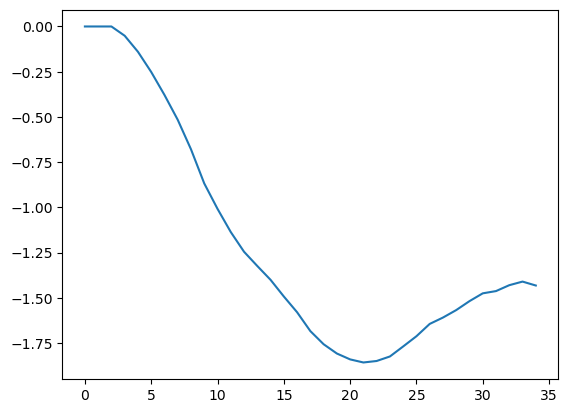

In [355]:
plt.plot(-states[:,2])

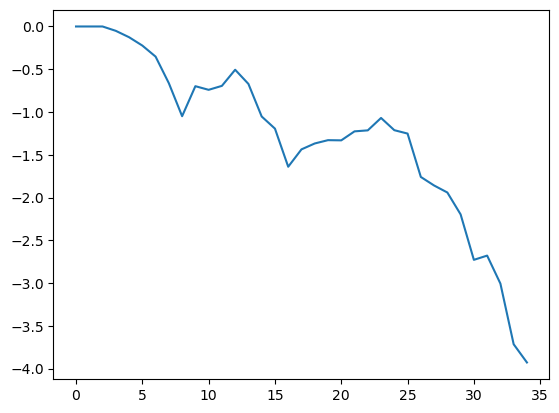

In [352]:
plt.plot(-states[:,1])